In [28]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from scipy.optimize import linear_sum_assignment

import warnings
warnings.simplefilter('ignore')


In [30]:
def align_cluster_labels(y_true, y_cluster):
    """Map cluster labels onto true labels via Hungarian algorithm."""
    y_true = np.asarray(y_true)
    y_cluster = np.asarray(y_cluster)
    true_labels = np.unique(y_true)
    cluster_labels = np.unique(y_cluster)
    n = max(len(true_labels), len(cluster_labels))
    cost = np.zeros((n, n), dtype=int)
    for i, t in enumerate(true_labels):
        for j, c in enumerate(cluster_labels):
            cost[i, j] = -np.sum((y_true == t) & (y_cluster == c))
    row_ind, col_ind = linear_sum_assignment(cost)
    mapping = {}
    for r, c in zip(row_ind, col_ind):
        if r < len(true_labels) and c < len(cluster_labels):
            mapping[cluster_labels[c]] = true_labels[r]
    return np.vectorize(lambda lab: mapping.get(lab, lab))(y_cluster)

def k_medians(X, k, max_iter=100, random_state=42):
    """Simple k-medians (L1) clustering for numeric arrays."""
    rng = np.random.default_rng(random_state)
    X = np.asarray(X)
    if X.ndim != 2:
        raise ValueError("X must be 2D")
    n = X.shape[0]
    if k <= 0 or k > n:
        raise ValueError("invalid k")
    medians = X[rng.choice(n, size=k, replace=False)]
    labels = np.zeros(n, dtype=int)
    for _ in range(max_iter):
        dists = np.sum(np.abs(X[:, None, :] - medians[None, :, :]), axis=2)
        new_labels = np.argmin(dists, axis=1)
        if np.array_equal(new_labels, labels):
            break
        labels = new_labels
        for j in range(k):
            members = X[labels == j]
            if len(members) == 0:
                medians[j] = X[rng.integers(0, n)]
            else:
                medians[j] = np.median(members, axis=0)
    return labels, medians


   gender  age_group  country          product_name        category  quantity  \
0  Female  Teenagers   Canada        Fitbit Versa 3     Electronics         3   
1    Male     Adults    China          Levi's Jeans         Apparel         4   
2    Male     Senior  Germany    Lego Star Wars Set            Toys         2   
3    Male  Teenagers   France          Dyson Vacuum  Home & Kitchen         4   
4  Female  Teenagers   Brazil  Adidas Running Shoes         Apparel         1   

   unit_price order_status    payment_method review_text  
0         229      Pending       Credit Card        good  
1          59      Pending            PayPal     average  
2          59    Delivered  Cash on Delivery        good  
3         399    Delivered  Cash on Delivery   very good  
4         110     Returned  Cash on Delivery   very good  
(10000, 10)
Klassen: ['Pending', 'Delivered', 'Returned', 'Shipped', 'Cancelled'] -> k= 5


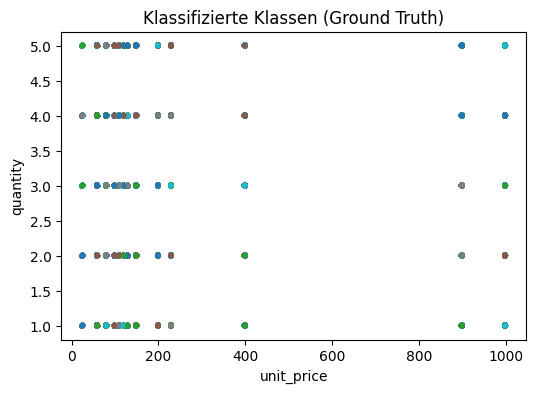

In [31]:
# Dataset aus dem supervised Learning (Aufgabe 1) laden
csv_path = Path("Aufgabe2/Data/ecommerce_dataset_10000.csv")
if not csv_path.exists():
    csv_path = Path("Data/ecommerce_dataset_10000.csv")
df = pd.read_csv(csv_path).dropna()
print(df.head())
print(df.shape)

# Klassifizierungsspalte (Target)
target_col = "order_status"
X = df.drop(columns=[target_col])
y = df[target_col]

# Features für Clustering numerisch machen (One-Hot + Scaling)
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns
pre = ColumnTransformer(
    [("num", StandardScaler(), num_cols),
     ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)],
    remainder="drop"
)
X_proc = pre.fit_transform(X)

# Labels als Zahlen (für Modelle/Plots)
y_codes, y_classes = pd.factorize(y)
k = len(y_classes)
print("Klassen:", list(y_classes), "-> k=", k)

# Zwei charakteristische Spalten für die Darstellung (aus Originaldaten)
plot_x_col = "unit_price"
plot_y_col = "quantity"
xs = df[plot_x_col].to_numpy()
ys = df[plot_y_col].to_numpy()

# Scatterplot mit klassifizierten Klassen
plt.figure(figsize=(6,4))
plt.scatter(xs, ys, c=y_codes, cmap="tab10", s=10)
plt.xlabel(plot_x_col)
plt.ylabel(plot_y_col)
plt.title("Klassifizierte Klassen (Ground Truth)")
plt.show()

# Split für supervised Baseline (GaussianNB)
x_train, x_test, y_train, y_test = train_test_split(
    X_proc, y_codes, test_size=0.3, random_state=42, stratify=y_codes
)


In [25]:
# Supervised Baseline: Naive Bayes auf dem gleichen Datensatz
classifier = GaussianNB()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)


In [24]:
# Auswertung der Vorhersagegenauigkeit
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Genauigkeit des Klassifizierers:", accuracy)


Genauigkeit des Klassifizierers: 0.198


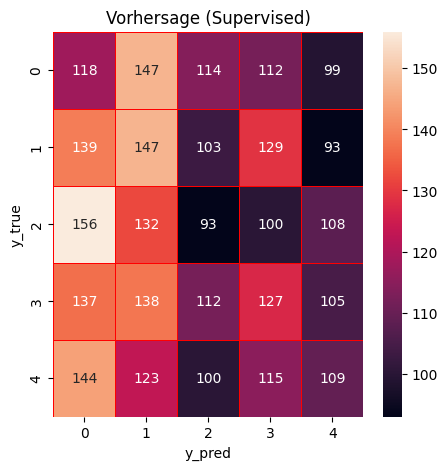

In [15]:
confmatrix = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(confmatrix, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("Vorhersage (Supervised)")
plt.show()


In [16]:
# Clusteranalyse (ohne Klassifizierungsspalte): k-Means und k-Medians
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
kmeans_labels = kmeans.fit_predict(X_proc)

kmed_labels, kmed_medians = k_medians(X_proc, k=k, random_state=42)

# Clusterlabels auf Klassenlabels mappen (sonst ist accuracy nicht sinnvoll)
kmeans_aligned = align_cluster_labels(y_codes, kmeans_labels)
kmed_aligned = align_cluster_labels(y_codes, kmed_labels)

print("Accuracy k-Means (aligned):", metrics.accuracy_score(y_codes, kmeans_aligned))
print("Accuracy k-Medians (aligned):", metrics.accuracy_score(y_codes, kmed_aligned))


Accuracy k-Means (aligned): 0.2094
Accuracy k-Medians (aligned): 0.207


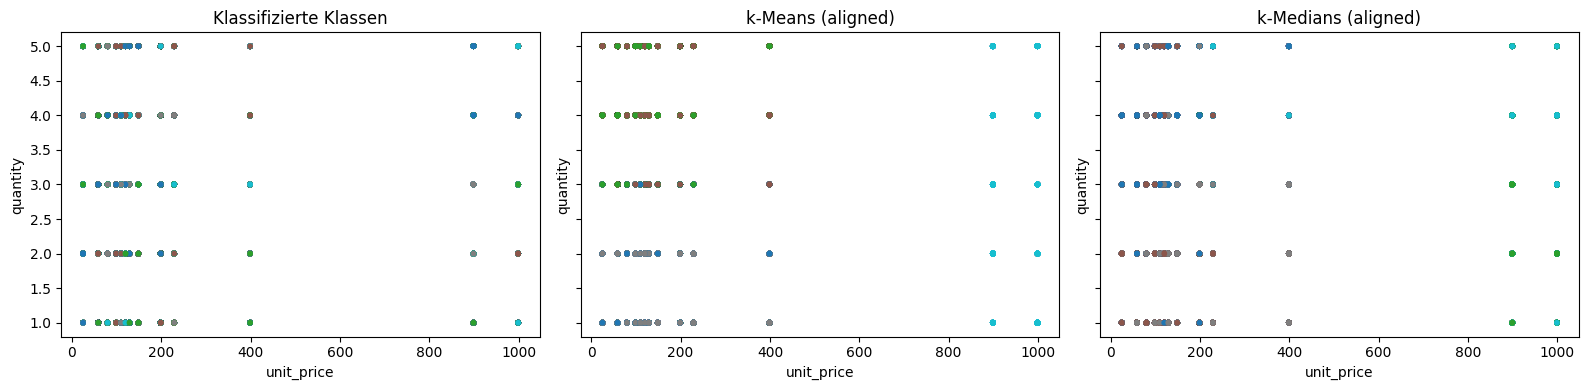

In [20]:
# Scatterplots: Ground Truth vs. Clusterergebnis (auf 2 gewählten Spalten)
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)
axes[0].scatter(xs, ys, c=y_codes, cmap="tab10", s=10)
axes[0].set_title("Klassifizierte Klassen")
axes[1].scatter(xs, ys, c=kmeans_aligned, cmap="tab10", s=10)
axes[1].set_title("k-Means (aligned)")
axes[2].scatter(xs, ys, c=kmed_aligned, cmap="tab10", s=10)
axes[2].set_title("k-Medians (aligned)")
for ax in axes:
    ax.set_xlabel(plot_x_col)
    ax.set_ylabel(plot_y_col)
plt.tight_layout()
plt.show()


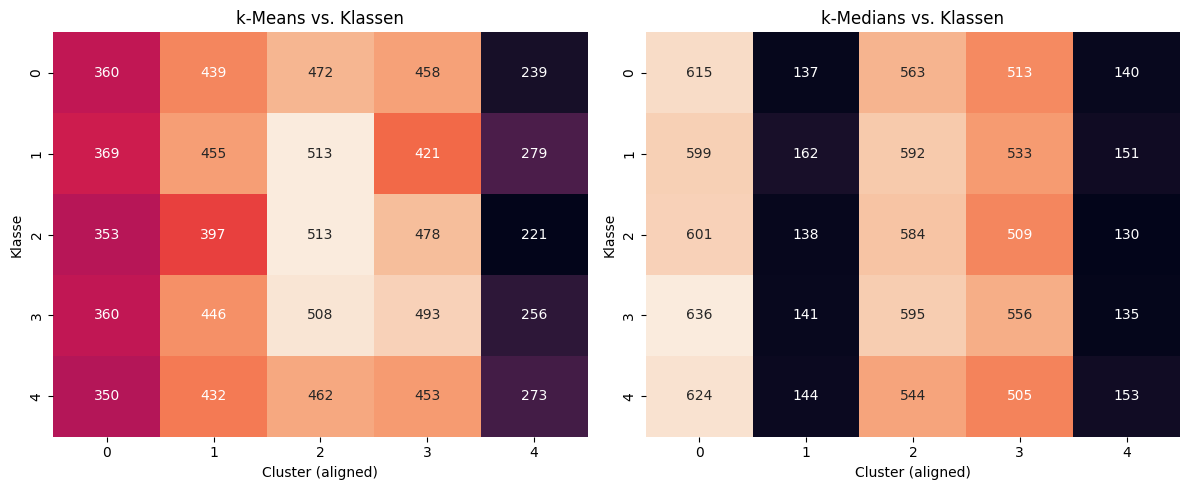

In [19]:
# Übereinstimmung Clustering vs. Klassen (Confusion-Matrix/Heatmap)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_kmeans = confusion_matrix(y_codes, kmeans_aligned)
sns.heatmap(cm_kmeans, annot=True, fmt="d", ax=axes[0], cbar=False)
axes[0].set_title("k-Means vs. Klassen")
axes[0].set_xlabel("Cluster (aligned)")
axes[0].set_ylabel("Klasse")

cm_kmed = confusion_matrix(y_codes, kmed_aligned)
sns.heatmap(cm_kmed, annot=True, fmt="d", ax=axes[1], cbar=False)
axes[1].set_title("k-Medians vs. Klassen")
axes[1].set_xlabel("Cluster (aligned)")
axes[1].set_ylabel("Klasse")

plt.tight_layout()
plt.show()
